 Generative Adversarial Network (GAN) with Radial Mask

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

In [ ]:
! pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:11<00:00, 15371573.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
from torch.utils.data import random_split

# Split the dataset into training and validation sets
train_size = int(0.8 * len(cifar10))
val_size = len(cifar10) - train_size
train_dataset, val_dataset = random_split(cifar10, [train_size, val_size])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

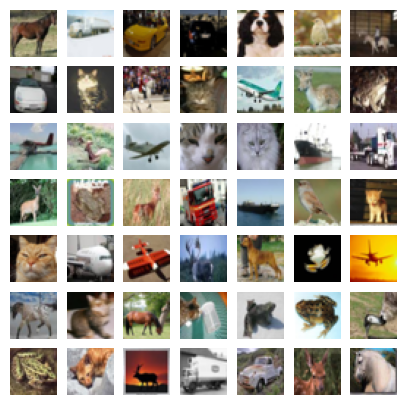

In [ ]:
fig, axes = plt.subplots(7, 7, figsize=(5, 5))

for i, (image, label) in enumerate(train_dataloader):
    if i >= 49:
        break
    # Define subplot
    ax = axes[i // 7, i % 7]
    # Turn off axis
    ax.axis('off')
    # Plot the image
    ax.imshow(image[0].permute(1, 2, 0).numpy())

plt.show()


In [ ]:
def createRadialMask(image, num_spokes=50, rings=500):
    # Define the size of the k-space matrix
    matrix_size_x = image.shape[2]
    matrix_size_y = image.shape[3]

    # Create an empty mask
    radialMask = torch.zeros_like(image)

    # Define the center of k-space
    center_x = matrix_size_x // 2
    center_y = matrix_size_y // 2

    for r in range(rings):
        # Define the maximum radius to sample
        max_radius = abs(min(center_x, center_y) - r)
        # Generate the radial sampling mask
        for i in range(num_spokes):
            angle = 2 * torch.tensor(np.pi * i / num_spokes)

            # Calculate scaled coordinates within the valid range
            x = center_x + max_radius * torch.cos(angle)
            y = center_y + max_radius * torch.sin(angle)

            # Ensure coordinates are within bounds
            x = torch.clamp(x, 0, matrix_size_x - 1).long()
            y = torch.clamp(y, 0, matrix_size_y - 1).long()
            radialMask[:, :, x, y] = 1.0

    return radialMask


In [ ]:

import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets

# Generator model
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Generator, self).__init__()

        # Define your generator architecture using convolutional layers, batch normalization, and activation functions
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, 3, kernel_size, stride, padding),  # Adjusted this line to have 3 output channels
            nn.Tanh()  # Added Tanh activation to ensure output is in the range [-1, 1]
        )

    def forward(self, input):
        # Generator forward pass
        output = self.model(input)
        return output

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Discriminator, self).__init__()

        # Define your discriminator architecture using convolutional layers, batch normalization, and activation functions
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, 1, kernel_size, stride, padding)  # Adjusted this line to have 1 output channel
        )

    def forward(self, input):
        output = self.model(input)
        return output

# Initialize discriminator with the correct number of input channels
generator = Generator(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
discriminator = Discriminator(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)



In [ ]:

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion_reconstruction = nn.MSELoss()
criterion_adversarial = nn.BCELoss()

In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

In [ ]:

num_epochs = 1
lambda_reconstruction = 0.1
print_interval = 25  # Print progress every 20 iterations

for epoch in range(1, num_epochs + 1):
    # Initialize tqdm with description for the epoch
    for step, data in tqdm(enumerate(train_dataloader, 0), desc=f"Epoch {epoch}/{num_epochs}"):
        # Get noisy images and apply radial mask
        noisy_images = data[0].to(device)
        radial_masked_images = noisy_images * createRadialMask(noisy_images)

        # Ensure radial_masked_images has the same shape as noisy_images
        radial_masked_images = radial_masked_images.view_as(noisy_images)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones((noisy_images.size(0), 1, 1, 1)).to(device)
        fake_labels = torch.zeros((noisy_images.size(0), 1, 1, 1)).to(device)

        # Forward pass for real images
        output_real = discriminator(noisy_images)
        # Apply Sigmoid activation to the discriminator output
        output_real_sigmoid = torch.sigmoid(output_real)
        loss_real = criterion_adversarial(output_real_sigmoid, real_labels.expand_as(output_real))

        # Forward pass for fake images generated by the generator
        generated_images = generator(radial_masked_images)
        output_fake = discriminator(generated_images.detach())
        # Apply Sigmoid activation to the discriminator output
        output_fake_sigmoid = torch.sigmoid(output_fake)
        loss_fake = criterion_adversarial(output_fake_sigmoid, fake_labels.expand_as(output_fake))

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        output_fake = discriminator(generated_images)
        output_fake_sigmoid = torch.sigmoid(output_fake)
        loss_G = criterion_adversarial(output_fake_sigmoid, real_labels.expand_as(output_fake))

        generated_images_resized = F.interpolate(generated_images, size=noisy_images.size()[2:], mode='bilinear', align_corners=False)
        loss_reconstruction = criterion_reconstruction(generated_images_resized, noisy_images)
        total_loss_G = loss_G + lambda_reconstruction * loss_reconstruction

        total_loss_G.backward()
        optimizer_G.step()

        # Calculate and print MSE loss every 20 iterations
        if step % print_interval == 0:
          mse_loss = loss_reconstruction.item()
          print(f"Epoch {epoch}/{num_epochs}, Step {step}, Adversarial Loss: {total_loss_G.item()}, MSE Loss: {mse_loss}")

    # Print progress
    print(f"Epoch {epoch}/{num_epochs}")


Epoch 1/1: 1it [00:06,  6.27s/it]

Epoch 1/1, Step 0, Adversarial Loss: 0.7084735631942749, MSE Loss: 0.47720208764076233


Epoch 1/1: 26it [02:35,  5.58s/it]

Epoch 1/1, Step 25, Adversarial Loss: 0.7594721913337708, MSE Loss: 0.250767320394516


Epoch 1/1: 51it [04:52,  5.60s/it]

Epoch 1/1, Step 50, Adversarial Loss: 0.811404287815094, MSE Loss: 0.307657390832901


Epoch 1/1: 76it [07:12,  6.05s/it]

Epoch 1/1, Step 75, Adversarial Loss: 0.9835073351860046, MSE Loss: 0.34500420093536377


Epoch 1/1: 101it [09:31,  5.55s/it]

Epoch 1/1, Step 100, Adversarial Loss: 0.8744116425514221, MSE Loss: 0.39491844177246094


Epoch 1/1: 126it [12:00,  6.15s/it]

Epoch 1/1, Step 125, Adversarial Loss: 0.9332733154296875, MSE Loss: 0.23725539445877075


Epoch 1/1: 151it [14:19,  5.49s/it]

Epoch 1/1, Step 150, Adversarial Loss: 0.9940491914749146, MSE Loss: 0.20725339651107788


Epoch 1/1: 176it [16:38,  5.46s/it]

Epoch 1/1, Step 175, Adversarial Loss: 0.9876194000244141, MSE Loss: 0.14155860245227814


Epoch 1/1: 201it [18:58,  5.58s/it]

Epoch 1/1, Step 200, Adversarial Loss: 1.1261577606201172, MSE Loss: 0.08571936935186386


Epoch 1/1: 226it [21:18,  5.79s/it]

Epoch 1/1, Step 225, Adversarial Loss: 1.0694811344146729, MSE Loss: 0.32104983925819397


Epoch 1/1: 251it [23:37,  5.54s/it]

Epoch 1/1, Step 250, Adversarial Loss: 1.0672616958618164, MSE Loss: 0.22870278358459473


Epoch 1/1: 276it [25:56,  5.45s/it]

Epoch 1/1, Step 275, Adversarial Loss: 1.2237118482589722, MSE Loss: 0.2309466004371643


Epoch 1/1: 301it [28:15,  5.43s/it]

Epoch 1/1, Step 300, Adversarial Loss: 1.257389783859253, MSE Loss: 0.2630225121974945


Epoch 1/1: 326it [30:34,  5.62s/it]

Epoch 1/1, Step 325, Adversarial Loss: 1.2896842956542969, MSE Loss: 0.10776088386774063


Epoch 1/1: 351it [32:54,  5.68s/it]

Epoch 1/1, Step 350, Adversarial Loss: 1.1520178318023682, MSE Loss: 0.12465003877878189


Epoch 1/1: 376it [35:12,  5.59s/it]

Epoch 1/1, Step 375, Adversarial Loss: 1.2361339330673218, MSE Loss: 0.2685707211494446


Epoch 1/1: 401it [37:36,  5.72s/it]

Epoch 1/1, Step 400, Adversarial Loss: 1.4875283241271973, MSE Loss: 0.17064189910888672


Epoch 1/1: 426it [40:01,  5.63s/it]

Epoch 1/1, Step 425, Adversarial Loss: 1.5469269752502441, MSE Loss: 0.19418193399906158


Epoch 1/1: 451it [42:23,  5.49s/it]

Epoch 1/1, Step 450, Adversarial Loss: 1.3151236772537231, MSE Loss: 0.15325932204723358


Epoch 1/1: 476it [44:43,  5.75s/it]

Epoch 1/1, Step 475, Adversarial Loss: 1.451985478401184, MSE Loss: 0.13402767479419708


Epoch 1/1: 501it [47:03,  5.59s/it]

Epoch 1/1, Step 500, Adversarial Loss: 1.4213809967041016, MSE Loss: 0.0742228701710701


Epoch 1/1: 526it [49:22,  5.57s/it]

Epoch 1/1, Step 525, Adversarial Loss: 1.5717850923538208, MSE Loss: 0.0877617597579956


Epoch 1/1: 551it [51:42,  5.54s/it]

Epoch 1/1, Step 550, Adversarial Loss: 1.3695130348205566, MSE Loss: 0.07410633563995361


Epoch 1/1: 576it [54:00,  5.47s/it]

Epoch 1/1, Step 575, Adversarial Loss: 1.2990485429763794, MSE Loss: 0.08113911002874374


Epoch 1/1: 601it [56:21,  5.67s/it]

Epoch 1/1, Step 600, Adversarial Loss: 0.9933643341064453, MSE Loss: 0.13170504570007324


Epoch 1/1: 625it [58:33,  5.62s/it]

Epoch 1/1


In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

# Function to calculate PSNR, SSIM, and MSE
def calculate_metrics(original, generated, clean):
    psnr = peak_signal_noise_ratio(clean, generated)
    # Calculate an appropriate win_size based on the minimum dimension of the images
    win_size = min(7, min(original.shape[-3], original.shape[-2]))
    ssim = structural_similarity(clean, generated, multichannel=True, win_size=win_size, channel_axis=-1)
    mse = mean_squared_error(clean, generated)
    return psnr, ssim, mse

print_interval = 20

# Evaluation on validation set
# Evaluation on validation set
with torch.no_grad():
    for i, val_data in tqdm(enumerate(val_dataloader, 0), desc="Validation"):
        val_noisy_images = val_data[0].to(device)
        val_radial_masked_images = val_noisy_images * createRadialMask(val_noisy_images)
        val_fake_images = generator(val_radial_masked_images)

        # Ensure radial_masked_images has the same shape as noisy_images
        val_radial_masked_images = val_radial_masked_images.view_as(val_noisy_images)

        # Resize or crop val_fake_images to match the dimensions of val_noisy_images
        val_fake_images_resized = F.interpolate(val_fake_images, size=val_noisy_images.size()[2:], mode='bilinear', align_corners=False)

        # Use ground truth clean images from the validation set
        val_cleaned_images = val_data[1].cpu().numpy()
        # Calculate evaluation metrics (e.g., PSNR, SSIM, MSE)
        psnr, ssim, mse = calculate_metrics(val_noisy_images.cpu().numpy(), val_fake_images_resized.cpu().numpy(), val_cleaned_images)

        # Print metrics every 20 iterations
        if i % print_interval == 0:
            print(f"Validation - Epoch: {epoch}, Iteration: {i}, PSNR: {psnr}, SSIM: {ssim}, MSE: {mse}")


Validation: 0it [00:00, ?it/s]<ipython-input-18-8c348e139e83>:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(clean, generated, multichannel=True, win_size=win_size, channel_axis=-1)
Validation: 1it [00:03,  3.66s/it]

Validation - Epoch: 1, Iteration: 0, PSNR: 7.195166141208449, SSIM: 0.2359408289194107, MSE: 0.19075827472016837


Validation: 21it [01:06,  3.05s/it]

Validation - Epoch: 1, Iteration: 20, PSNR: 7.805186389819761, SSIM: 0.27553844451904297, MSE: 0.16576061944414233


Validation: 41it [02:10,  3.21s/it]

Validation - Epoch: 1, Iteration: 40, PSNR: 7.191766070472178, SSIM: 0.2526949644088745, MSE: 0.1909076769369881


Validation: 61it [03:12,  2.96s/it]

Validation - Epoch: 1, Iteration: 60, PSNR: 7.442727186114137, SSIM: 0.28798431158065796, MSE: 0.18018858772075316


Validation: 81it [04:18,  3.08s/it]

Validation - Epoch: 1, Iteration: 80, PSNR: 7.229613937581352, SSIM: 0.26977822184562683, MSE: 0.18925118444127698


Validation: 101it [05:22,  3.25s/it]

Validation - Epoch: 1, Iteration: 100, PSNR: 7.1693820568260875, SSIM: 0.22779005765914917, MSE: 0.19189417610871387


Validation: 121it [06:25,  3.18s/it]

Validation - Epoch: 1, Iteration: 120, PSNR: 7.448146394084089, SSIM: 0.28340017795562744, MSE: 0.17996388524582205


Validation: 141it [07:27,  2.98s/it]

Validation - Epoch: 1, Iteration: 140, PSNR: 7.609839924812212, SSIM: 0.22298559546470642, MSE: 0.17338679046484265


Validation: 157it [08:14,  3.15s/it]


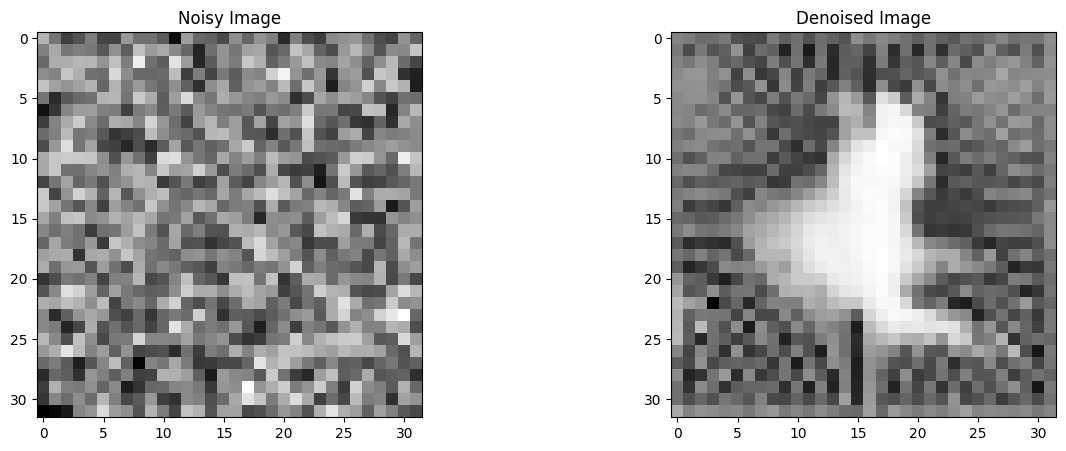

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(original, generated):
    # Display a few examples side by side
    num_examples = min(generated.shape[0], 1)  # Display at most 1 example
    for idx in range(num_examples):
        plt.figure(figsize=(15, 5))

        # Display noisy image
        plt.subplot(1, 2, 1)
        plt.imshow(original[idx, 0], cmap='gray')
        plt.title('Noisy Image')

        # Display denoised image
        plt.subplot(1, 2, 2)
        plt.imshow(generated[idx, 0], cmap='gray')
        plt.title('Denoised Image')
        plt.show()

visualize_results(val_noisy_images_resized.cpu().numpy(), val_fake_images_resized.cpu().numpy())


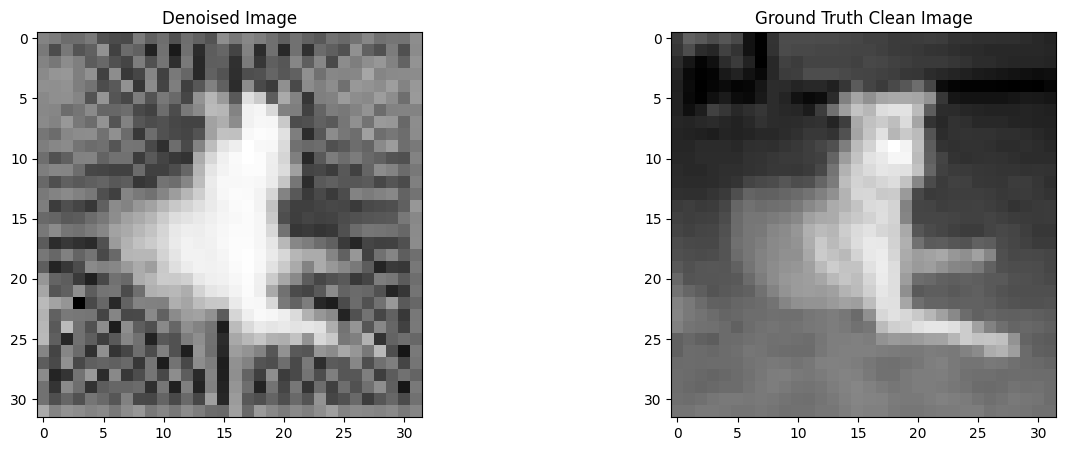

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(generated, clean):
    # Display a few examples side by side
    num_examples = min(generated.shape[0], 1)  # Display at most 1 example
    for idx in range(num_examples):
        plt.figure(figsize=(15, 5))

        # Display denoised image
        plt.subplot(1, 2, 1)
        plt.imshow(generated[idx, 0], cmap='gray')
        plt.title('Denoised Image')

        # Display ground truth clean image
        plt.subplot(1, 2, 2)
        plt.imshow(clean[idx, 0], cmap='gray')
        plt.title('Ground Truth Clean Image')

        plt.show()

# Example usage:
visualize_results(val_fake_images_resized.cpu().numpy(), val_cleaned_images)
